# 1. What is NLP?
- Subfield of AI and linguistics that focuses on the interaction between computers and humans through natural language.
- The goal - to enable computers to understand, interpret, and generate human language in a way that is both meaningful and useful.

# 2. Word Clouds
- Visualize words and counts such as $(size\_of\_word) \ \ \alpha \ \ (word\_count)$
- Manually create a list of tuples (word, freq in job posts)
- install wordcloud to plot: pip install wordcloud 

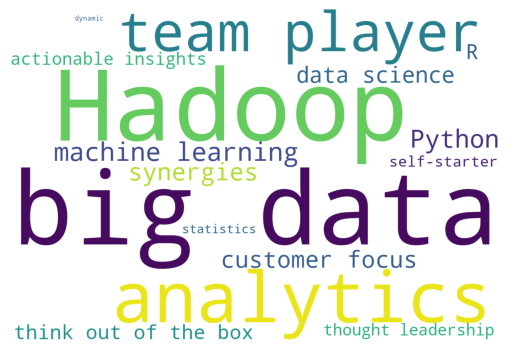

In [2]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Example data [(word, freq in job posts)]
data = [
    ("big data", 100), ("Hadoop", 95), ("Python", 75),
    ("R", 50), ("machine learning", 80), ("statistics", 20),
    ("data science", 60), ("analytics", 90),
    ("team player", 85), ("dynamic", 2), ("synergies", 70),
    ("actionable insights", 40), ("think out of the box", 45),
    ("self-starter", 30), ("customer focus", 65),
    ("thought leadership", 35)]

# Convert data into dict
word_freq = {word: freq for word, freq in data}

# Create word cloud
wordcloud = WordCloud(background_color='white', width=1200, height=800).generate_from_frequencies(word_freq)

# Display using matplotlib
plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

- Is there any use of this data plot? - No, it just looks neat and doesn't tell anything.
- Let's scatter them so that - horizontal position indicates posting popularity and - vertical position indicates resume popularity, whichproduces a visualization that conveys a few insights.

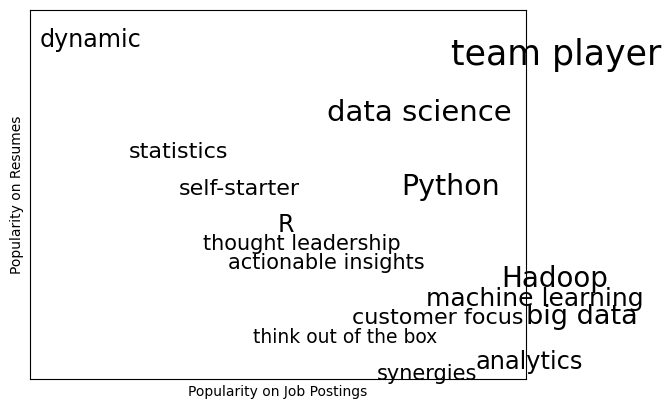

In [3]:
from matplotlib import pyplot as plt

data = [
    ("big data", 100, 15), ("Hadoop", 95, 25), ("Python", 75, 50),
    ("R", 50, 40), ("machine learning", 80, 20), ("statistics", 20, 60),
    ("data science", 60, 70), ("analytics", 90, 3),
    ("team player", 85, 85), ("dynamic", 2, 90), ("synergies", 70, 0),
    ("actionable insights", 40, 30), ("think out of the box", 45, 10),
    ("self-starter", 30, 50), ("customer focus", 65, 15),
    ("thought leadership", 35, 35)
]

# To also vary textsize wrt total counts
def text_size(total: int) -> float:
    """
    equals 8 if total is 0, 28 if total is 200
    """
    return 8 + ((total / 200) * 20)

for word, job_popularity, resume_popularity in data:
    plt.text(job_popularity, resume_popularity, word, size=text_size(job_popularity+resume_popularity))

plt.xlabel("Popularity on Job Postings")
plt.ylabel("Popularity on Resumes")
plt.axis([0,100, 0,100])
plt.xticks([])
plt.yticks([])
plt.show()

# 3. n-Gram Language Models

- n-gram is used in NLP to model sequence of items in text.
- The "n" in n-gram refers to the number of items in the sequence.
- Example:
  > - Unigram (1-gram):  
  > Example: In the sentence "I love NLP," the unigrams are ["I", "love", "NLP"].
  > - Bigram (2-gram):  
  >  Example: In the sentence "I love NLP," the bigrams are ["I love", "love NLP"].
  > - Trigram (3-gram):  
  > Example: In the sentence "I love NLP," the trigrams are ["I love NLP"].

- For example, we want to write thousands of web pages programmatically. How can we do this?
- We will take a sample text, and learn the n-gram of the texts, and using the Learned model we will generate new text.
- Sample data url: http://radar.oreilly.com/2010/06/what-is-data-science.html
- Issue to be resolved first:
  > 1. apostrophes in the text are actually the Unicode character u"\u2019".  
  >    We’ll create a helper function to replace them with normal apostrophes:

In [4]:
def fix_unicode(text: str) -> str:
    return text.replace(u"\u2019", "'")

In [5]:
# Get the text of web page

import re
from bs4 import BeautifulSoup
import requests

url = 'http://radar.oreilly.com/2010/06/what-is-data-science.html'
html = requests.get(url).text
soup = BeautifulSoup(html, 'html5lib')
# print(soup)

content = soup.find('div', id='body-content')
# print(content('p'))

regex = r"[\w']+|[\.]"
document = []

for paragraph in content('p'):
    words = re.findall(regex, fix_unicode(paragraph.text))
    document.extend(words)

print(document[:20])

['Sections', 'Download', 'this', 'free', 'report', "We've", 'all', 'heard', 'it', 'according', 'to', 'Hal', 'Varian', 'statistics', 'is', 'the', 'next', 'sexy', 'job', '.']


- Current State:
> - The text data we extracted still contains some unnecessary parts
> - (e.g., section titles, mid-sentence periods like in "Web 2.0", captions, and lists).
- Ideal State:
> - Ideally, we should clean this text to remove these extraneous parts, but for now, we'll proceed with the data as it is.

**Modeling Language with Bigrams**

What is a Bigram Model?
> - A bigram is a pair of consecutive words in a text.
> - For example, in the sentence "data science is cool", the bigrams are ("data", "science"), ("science", "is"), and ("is", "cool").

> - Bigram Model uses these pairs of words to understand the structure of the text.
> - It helps in predicting the next word based on the current word.

How Does it Work?

> Starting with a Word:
> - Begin with a starting word. For example, let's start with the word "data".  

> Finding the Next Word:
> - Look at all the words that come immediately after "data" in the text.
> - Suppose in the text, "data" is followed by "science", "mining", and "analysis".
> - Randomly choose one of these words as the next word. Let's say we pick "science".

> Repeating the Process:
> - Now, our current word is "science".
> - Look at all the words that follow "science" in the text.
> - Suppose "science" is followed by "is", "and", and "in".
> - Randomly pick one of these words. Let's say we pick "is".

> Continuing Until a Period:
> - Repeat this process of finding the next word and appending it to our sentence until we encounter a period (".").
> - A period signifies the end of a sentence.

Example Sentence Generation
> - Let's say we have the text: "Data science is cool. Data mining is useful."
> - Using the bigram model, we might generate a sentence like:
> - Start with "Data"
> - Possible next words: "science", "mining"
> - Suppose we pick "science"
> - Current sentence: "Data science"
> - Next words after "science": "is"
> - Current sentence: "Data science is"
> - Next words after "is": "cool", "useful"
> - Suppose we pick "cool"
> - Current sentence: "Data science is cool"
> - Next word after "cool": period (".")
> - Sentence complete: "Data science is cool."


In [6]:
from collections import defaultdict
import random

transitions = defaultdict(list) # Automatically create an empty list if a key doesn't exist
x=zip(document, document[1:]) # create list of tuples of each consecutive word pair
# print(*x)

for prev, current in x:
    transitions[prev].append(current)  # create dict of {word : its possible consecutive words list}
# print(transitions)
    
# Let's generate sentences
def generate_using_bigrams() -> str:
    current = '.' # This means the next word will start a sentence
    result = []
    while True: # Starts an infinite loop that will keep executing the code inside it until it's explicitly broken out of. 
                # This is useful when you don't know in advance how many iterations you'll need.
        next_word_candidates = transitions[current]
        current = random.choice(next_word_candidates) # Choose random next word
        result.append(current) 
        if current == '.':
            return " ".join(result)  # joins the elements if list-result with a space between them



In [7]:
generate_using_bigrams()  # gibberish sentence generated

"Computing a 32 GB microSD card measures around faces cars or Office 2015 they're entrepreneurs ."

- To make sentences less gibberishy, we can use a trigram model.
- This model looks at three consecutive words (triplets) instead of two (bigrams).
- By considering the context of two previous words, we can generate more coherent and meaningful sentences.


In [8]:
trigram_transitions = defaultdict(list)
starts = []

for prev, current, next in zip(document, document[1:], document[2:]):
    if prev == '.':
        starts.append(current)
    trigram_transitions[(prev, current)].append(next)

# Top 5 elements of dict
keys = list(trigram_transitions.keys()) 
for i in range(10):
    print(keys[i],':', trigram_transitions[keys[i]])

('Sections', 'Download') : ['this']
('Download', 'this') : ['free']
('this', 'free') : ['report']
('free', 'report') : ["We've"]
('report', "We've") : ['all']
("We've", 'all') : ['heard', 'heard', 'heard']
('all', 'heard') : ['it', 'a', 'the']
('heard', 'it') : ['according']
('it', 'according') : ['to']
('according', 'to') : ['Hal']


In [9]:
def generate_using_trigrams() -> str:
    current = random.choice(starts)
    prev = '.'
    result = [current]
    while True:
        next_word_candidates = trigram_transitions[(prev, current)]
        next_word = random.choice(next_word_candidates)
        prev,current = current, next_word
        result.append(current)

        if current == '.':
            return " ".join(result)

In [10]:
generate_using_trigrams() # Producing better sentences than bigram

'Many sources of wild data are valid .'

- Of course, they sound better because at each step the generation process has fewer choices, and at many steps only a single choice.
- This means that we frequently generate sentences (or at least long phrases) that were seen verbatim in the original data.
- Having more data would help; it would also work better if we collected n-grams from multiple essays about data science

# 4. Grammars

- Here we create rules of grammar to generate sentences.
- We will define the grammar as follows:
  > - Word starting with undersocre is expandable
  > - Others are terminal symbols

**Sentence generation process**
> 1. Start with a sentence rule
> 2. Exapand the rules
> 3. Repeat the expansion until all rules are replaced by terminal symbols

In [11]:
from typing import Dict, List
Grammar = Dict[str, List[str]] # define grammar type

grammar = {
    "_S" : ["_NP _VP"],                      # Sentence -> Noun Phrase + Verb Phrase
    "_NP" : ["_N",                           # Noun Phrase -> Noun
             "_A _NP _P _A _N"],             # or Adjective + Noun Phrase + Preposition + Adjective + Noun 
                                             # _NP contanis one _NP -- grammar can be recursive
                                             # Recusrion allows even finite grammar to generate infinitely many different sentences
    "_VP" : ["_V",                           # Verb Phrase -> Verb
             "_V _NP"],                      # or Verb + Noun Phrase
    "_N" : ["data science", "Python", "regression"],    # Nouns
    "_A" : ["big", "linear", "logistic"],    # Adjectives
    "_P" : ["about", "near"],                # Prepositions
    "_V" : ["learns", "trains", "tests", "is"]  # Verbs
}

**Example of Sentence Generation**
1. Start with "_S"
2. Expand to ["_NP _VP"]
3. - Randomly exapnd _NP -- lets's say "_N"
   - Randomly expand _VP -- let's say "_V _NP"
   >  Updated to -- ["_N _V _NP"]
4. - Exapnd _N -- "Python"
   - Exapnd _V -- "tests"
   - Exapnd _NP -- "_N"
   >  Updated to -- ["Python", "tests", "_N"]
5. - Exapnd _N -- "regression"
   >  Updated to -- ["Python", "tests", "regression"]

- Final statement generated is
>  "Python tests regression"

In [12]:
# Helper function to check if token is terminal token
def is_terminal(token: str) -> bool:
    return token[0] != "_"

def expand(grammar: Grammar, tokens: List[str]) -> List[str]:
    print(f"{tokens=}")
    for i, token in enumerate(tokens):
        print(f"{i=}")
        # print(token)
        # Skip if the token is a terminal (a word)
        iteration =+1
        if is_terminal(token):
            continue
        
        # Choose a random production for the non-terminal token
        replacement = random.choice(grammar[token])
        print(replacement)
        
        if is_terminal(replacement):
            # Replace the token with the terminal word
            tokens[i] = replacement
        else:
            # Replace the token with a sequence of non-terminals
            tokens = tokens[:i] + replacement.split() + tokens[(i+1):]
        
        # Recursively expand the new list of tokens
        return expand(grammar, tokens)
    
    # If all tokens are terminal, return the list of tokens
    return tokens

def generate_sentence(grammar: Grammar) -> List[str]:
    return expand(grammar, ["_S"])

    

In [13]:
# Function to generate a sentence
def generate_sentence(grammar: Grammar) -> List[str]:
    return expand(grammar, ["_S"])

# Generate and print a sentence
sentence = generate_sentence(grammar)
print(" ".join(sentence))

tokens=['_S']
i=0
_NP _VP
tokens=['_NP', '_VP']
i=0
_A _NP _P _A _N
tokens=['_A', '_NP', '_P', '_A', '_N', '_VP']
i=0
linear
tokens=['linear', '_NP', '_P', '_A', '_N', '_VP']
i=0
i=1
_A _NP _P _A _N
tokens=['linear', '_A', '_NP', '_P', '_A', '_N', '_P', '_A', '_N', '_VP']
i=0
i=1
logistic
tokens=['linear', 'logistic', '_NP', '_P', '_A', '_N', '_P', '_A', '_N', '_VP']
i=0
i=1
i=2
_N
tokens=['linear', 'logistic', '_N', '_P', '_A', '_N', '_P', '_A', '_N', '_VP']
i=0
i=1
i=2
regression
tokens=['linear', 'logistic', 'regression', '_P', '_A', '_N', '_P', '_A', '_N', '_VP']
i=0
i=1
i=2
i=3
near
tokens=['linear', 'logistic', 'regression', 'near', '_A', '_N', '_P', '_A', '_N', '_VP']
i=0
i=1
i=2
i=3
i=4
big
tokens=['linear', 'logistic', 'regression', 'near', 'big', '_N', '_P', '_A', '_N', '_VP']
i=0
i=1
i=2
i=3
i=4
i=5
regression
tokens=['linear', 'logistic', 'regression', 'near', 'big', 'regression', '_P', '_A', '_N', '_VP']
i=0
i=1
i=2
i=3
i=4
i=5
i=6
near
tokens=['linear', 'logistic', 'regre

# 5. Gibbs Sampling
- Gibbs sampling is a technique for <u> generating samples from multidimensional distributions</u> when we only know some of the conditional distributions.

- Used in Bayesian Inference(Posterior prob) and LDA for topic modeling.


- Its easy to generate samples using some common distributions. Eg.:
  >- random.random() will generate all samples ranging from 0-1 -- means we can get UNIFORM Distributed random samples
  >- inverse_normal_cdf(random.random()) -- will generate NORMAL distributed samples.

- But some distributions are harder to sample from.


Example Scenario:
> Imagine we have two dice:
> - x is the value of the first die.
> - y is the sum of the values of both dice.  
> - We want to generate lots of pairs (x,y) where x and y follow their respective distributions.

- This can be done in two ways: Direct Sampling and Gibbs Sampling
1. **Direct Sampling**  
If we can roll the dice directly, generating the pairs is straightforward:
> 1. **Roll the first die (d1).**
> 2. **Roll the second die (d2).**
> 3. **Calculate y as the sum of d1 and d2.**


In [14]:
# Direct Sampling

from typing import Tuple
import random

def roll_a_die() -> int:
    return random.choice([1,2,3,4,5,6])

def direct_sample() -> Tuple[int, int]:
    d1 = roll_a_die()
    d2 = roll_a_die()
    return d1, d1+d2

2. **Gibbs Sampling**

Let's say we only know how to sample based on one value given the other:

> 1. Given x, what is y?
>  - If we know x, y can be any of ( x + 1, x + 2, x + 3, x + 4, x + 5, x + 6 ).

> 2. Given y, what is x?
> - This is a bit trickier because:
> - If y is small (e.g., 2), x must be small (e.g., 1).
> - If y is larger (e.g., 11), x could be any of the higher values (e.g., 5 or 6).

So, in Gibbs Sampling
1. **Initialize** with any valid values for x and y.
2. **Repeat** for a number of iterations:
   - **Update x** using the conditional distribution given y.
   - **Update y** using the conditional distribution given x.


In [15]:
def random_y_given_x(x: int) -> int:
    """
    equally likely to be x + 1, x + 2, ... , x + 6
    """
    return x + roll_a_die()

def random_x_given_y(y: int) -> int:
    if y <= 7:
        # if the total is 7 or less, the first die is equally likely to be
        # 1, 2, ..., (total - 1)
        return random.randrange(1, y)
    else:
        # if the total is 7 or more, the first die is equally likely to be
        # (total - 6), (total - 5), ..., 6
        return random.randrange(y - 6, 7)

In [16]:
def gibbs_sample(num_iters: int = 100) -> Tuple[int, int]:
    x, y = 1, 2 # Choose any random values
    for _ in range(num_iters):
        x = random_x_given_y(y)
        y = random_y_given_x(x)
    return x, y

In [17]:
# Compare direct sample and Gibbs Sample
from typing import Dict, List
from collections import defaultdict
def compare_distributions(num_samples: int = 1000) -> Dict[int, List[int]]:
    counts = defaultdict(lambda: [0,0])
    
    for _ in range(num_samples):
        counts[gibbs_sample()][0] +=1
        # print(counts)
        counts[direct_sample()][1] +=1
        # print(counts)
    return counts

In [18]:
compare_distributions(1000)

defaultdict(<function __main__.compare_distributions.<locals>.<lambda>()>,
            {(3, 7): [28, 30],
             (6, 7): [25, 21],
             (4, 8): [25, 28],
             (6, 10): [23, 27],
             (6, 8): [25, 20],
             (2, 6): [21, 33],
             (5, 10): [19, 37],
             (6, 11): [33, 29],
             (1, 5): [29, 39],
             (5, 11): [40, 25],
             (1, 3): [20, 35],
             (4, 7): [22, 21],
             (3, 9): [28, 28],
             (3, 8): [36, 33],
             (2, 3): [21, 25],
             (2, 5): [38, 30],
             (5, 9): [32, 24],
             (6, 9): [27, 30],
             (5, 7): [28, 30],
             (2, 8): [27, 23],
             (2, 7): [27, 29],
             (5, 6): [26, 27],
             (5, 8): [28, 25],
             (1, 2): [36, 30],
             (1, 4): [22, 25],
             (2, 4): [38, 32],
             (1, 7): [27, 29],
             (1, 6): [30, 20],
             (4, 5): [29, 27],
             (3, 5): [

# 6. Topic Modeling
- To find out main themes in a large text/document
- Can be used in document classification, summarization etc

**Keywords:**
> 1. Document: A single piece of text, such as an article or a paper.
> 2. Corpus: A collection of documents.
> 3. Topic: A distribution over words that represents a theme or subject within the corpus.
> 4. Word Distribution: Each topic is characterized by a distribution of words, where each word has a probability of belonging to that topic.

**Latent Dirichlet allocation (LDA)**
- Similar to Naive bayes probabilitic model.  
- LDA is Generative probabilistic model that assumes:
> 1. Each Document is mixture of Topics. 
> 2. Each Topic is mixture of Words.
> - LDA works by trying to reconstruct the documents in the Corpus using a set of topics.
> - It assigns probabilities to Topics within each Document [doc1: p(t1), p(t2)..etc,]
> - and probabilities to Words within each Topic. [t1: p(w1), p(w2)...etc, ]

**Steps in LDA**
1. Initialization: Randomly assign each word in each document to one of the K topics.

2. Iteration:
> - For each document, update the topic distribution based on the current assignment of words to topics.
> - For each word, update the word distribution for the topic it is assigned to.
> - Reassign each word to a new topic based on the updated distributions.
3. Convergence: Repeat the iteration until the topic assignments stabilize.

- **The process involves estimating the probabilities of topics within each document based on the probabilities of words within each topic and the observed words in each document.**

Let's do the mathematics of LDA. Assume

1. $K$: Fixed number of Topics are there
2. Under each Topic there is probability list of each Word $(P(w|k))$: We will assign it randomly.
   > - Means each document becomes a mixture of Topics.
3. To generate a document
   > - we will randomly pick a topic
   > - then randomly pick a word from Topic's word dictribution.

- we have a <u>collection of $documents$<u>, each of which is a list of words.
- we have a <u>collection of $document\_topics$<u> for each document in collections of documents that assigns a topic (here a number between $0$ and $K – 1$) to each word in each document.
> - e.g. the fifth word in the fourth document is: $documents[3][4]$
> - the topic from which that word was chosen is: $document\_topics[3][4]$
- This very explicitly defines <u> each document’s distribution over topics<u>, and it <u>implicitly defines each topic’s distribution over words<u>.

- We can estimate the likelihood that topic 1 produces a certain word by comparing how many times topic 1 produces that word with how manytimes topic 1 produces any word.
(Similarly, when we built a spam filter in Chapter 13, we compared how many times each word appeared in spams with the total number of words appearing in spams.)
- Although these topics are just numbers, we can give them descriptive names by looking at the words on which they put the heaviest weight.
- We just have to somehow generate the $document_topics$. This is where Gibbs sampling comes into play.
> 1. We start by assigning every word in every document a topic completely at random.
> 2. Now we go through each document one word at a time. For that word and document, we construct weights for each topic that depend on the(current) distribution of topics in that document and the (current) distribution of words for that topic.
> 3. We then use those weights to sample a new topic for that word. If we iterate this process many times, we will end up with a joint sample from the topic–word distribution and the document–topic distribution.

In [37]:
# To start with, we’ll need a function to randomly choose an index based on an arbitrary set of weights:

def sample_from(weights: List[float]) -> int:
    """returns i with probability weights[i] / sum(weights)"""
    total = sum(weights)
    rnd = total * random.random() # uniform between 0 and total
    for i, w in enumerate(weights):
        rnd -= w # return the smallest i such that
        if rnd <= 0: 
            return i # weights[0] + ... + weights[i] >= rnd

In [38]:
# For instance, if you give it weights [1, 1, 3], then one-fifth of the time it
# will return 0, one-fifth of the time it will return 1, and three-fifths of the time it will return 2. 
# Let’s write a test:

from collections import Counter
# Draw 1000 times and count
draws = Counter(sample_from([0.1, 0.1, 0.8]) for _ in range(1000))
assert 10 < draws[0] < 190 # should be ~10%, this is a really loose test
assert 10 < draws[1] < 190 # should be ~10%, this is a really loose test
assert 650 < draws[2] < 950 # should be ~80%, this is a really loose test
assert draws[0] + draws[1] + draws[2] == 1000

In [41]:
draws[2]

815